# Pipeline MRTrix 0.2 Preprocessing Workflow

This workflow performs the specific preprocessing of the dwMRI data in order to perform tracking using <b>MRTrix 0.2</b> as direct legacy conversion from the old pipeline

### Handle imports

In [1]:
from nipype.interfaces import mrtrix, fsl
from nipype import Node, Workflow
from nipype.interfaces.utility import IdentityInterface

import numpy as np
import logging

### Start the logging

In [2]:
logger = logging.getLogger('interface')
logger.setLevel(logging.INFO)
# create console handler and set level to debug
ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
# create formatter
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
# add formatter to ch
ch.setFormatter(formatter)
# add ch to logger
logger.addHandler(ch)

### Define parameters

In [3]:
# Threshold for FA during single fiber voxel mask estimation
absolute_threshold_value = 0.7
# Number of erosion passes during single voxel fiber mask estimation
number_of_passes = 1

# Define default filenames
fileNames = {
    'gradFile': 'btable.b',
    'dtFile': 'dt.mif',
    'faFile': 'fa.mif',
    'evFile': 'ev.mif',
    'singleFiberFile': 'singleFibers.mif',
    'responseFile': 'response.txt',
    'csdFile': 'CSD.mif'
            }

### Define input and outpute nodes

In [4]:
inputNode = Node(IdentityInterface(fields = ['dwi_file',
                                            'bval_file',
                                            'bvec_file',
                                            'wmmask',
                                            'tracking_dir']), 
                 name = 'input_node')


outputNode = Node(IdentityInterface(fields = ['spherical_harmonics_image']), 
                  name = 'output_node')

### Utility functions

In [5]:
def fileNameBuilder(path, fname):
    return path + '/' + fname

# Get the maximum possbile spherical-harmonics order 
# out of the data because mrtrix itself is not capable of doing this safely
def estimateMaxHarmOrder(bval_file):
    with open(bval_file,'r') as f:
        tmp = f.read()
        tmp = np.asarray(tmp.split())
    
    f.close()
    
    return np.count_nonzero(tmp > '0')

### MRTrix specific preprocessing

In [6]:
# First convert the FSL-like input of bval and bvec into mrtrix format
fsl2mrtrixNode = Node(mrtrix.FSL2MRTrix(), name = 'fsl_2_mrtrix')

#Diffusion tensor images
dwi2tensorNode = Node(mrtrix.DWI2Tensor(), name = 'dwi_2_tensor')
#dwi2tensor dwi.mif -grad btable.b dt.mif

#Fractional anisotropy (FA) map
#tensor2FA dt.mif fa.mif
tensor2faNode = Node(mrtrix.Tensor2FractionalAnisotropy(), name = 'tensor_2_FA')

#Remove noisy background by multiplying the FA Image with the binary brainmask
#mrmult fa.mif wmmask.mif fa_corr.mif
mrmultNode = Node(fsl.BinaryMaths(), name = 'mrmult')
mrmultNode.inputs.operation = 'mul'

#Eigenvector (EV) map
#tensor2vector dt.mif ev.mif
tensor2vectorNode = Node(mrtrix.Tensor2Vector(), name = 'tensor_2_vector')

#Scale the EV map by the FA Image
#mrmult ev.mif fa_corr.mif ev_scaled.mif
scaleEvNode = Node(fsl.BinaryMaths(), name = 'scale_ev')
scaleEvNode.inputs.operation = 'mul'

#Mask of single-fibre voxels
#erode wmmask.mif -npass 1 - | mrmult fa_corr.mif - - | threshold - -abs 0.7 sf.mif
erodeNode = Node(mrtrix.Erode(), name = 'erode_wmmask')
erodeNode.inputs.number_of_passes = number_of_passes

cleanFaNode = Node(fsl.BinaryMaths(), name = 'multiplyFA_Mask')
cleanFaNode.inputs.operation = 'mul'

thresholdFANode = Node(mrtrix.Threshold(), name = 'threshold_FA')
thresholdFANode.inputs.absolute_threshold_value = absolute_threshold_value

#Response function coefficient
#estimate_response dwi.mif -grad btable.b -lmax ${lmax} sf.mif response.txt
estResponseNode = Node(mrtrix.EstimateResponseForSH(), name = 'estimate_deconv_response')

#CSD computation
#csdeconv dwi.mif -grad btable.b response.txt -lmax ${lmax} -mask wmmask.mif CSD8.mif
csdNode = Node(mrtrix.ConstrainedSphericalDeconvolution(), name = 'compute_CSD')

### Connect the Nodes in the workflow

In [15]:
wf = Workflow(name = 'MRTrix_preproc')

# First do connect preprocessing
wf.connect([
        (inputNode, fsl2mrtrixNode, [('bval_file', 'bval_file'),
                                        ('bvec_file', 'bvec_file'),
                                        (('tracking_dir', fileNameBuilder, fileNames['gradFile']), 'out_encoding_file')]),
        (inputNode, dwi2tensorNode, [('dwi_file', 'in_file'),
                                    (('tracking_dir', fileNameBuilder, fileNames['dtFile']), 'out_filename')]),
        (fsl2mrtrixNode, dwi2tensorNode, [('encoding_file', 'encoding_file')]),
        (dwi2tensorNode, tensor2faNode, [('tensor', 'in_file')]),
        (inputNode, tensor2faNode, [(('tracking_dir', fileNameBuilder, fileNames['faFile']), 'out_filename')]),
        (tensor2faNode, mrmultNode, [('FA', 'in_file')]),
        (inputNode, mrmultNode, [('wmmask', 'operand_file')]),
        (inputNode, mrmultNode, [(('tracking_dir', fileNameBuilder, fileNames['faFile']), 'out_file')]),
        (dwi2tensorNode, tensor2vectorNode, [('tensor', 'in_file')]),
        (inputNode, tensor2vectorNode, [(('tracking_dir', fileNameBuilder, fileNames['evFile']), 'out_filename')]),
        (tensor2vectorNode, scaleEvNode, [('vector', 'in_file')]),
        (mrmultNode, scaleEvNode, [('out_file', 'operand_file')]),
        (inputNode, scaleEvNode, [(('tracking_dir', fileNameBuilder, fileNames['evFile']), 'out_file')]),
        (inputNode, erodeNode, [('wmmask', 'in_file'),
                               (('tracking_dir', fileNameBuilder, fileNames['singleFiberFile']), 'out_filename')]),
        (erodeNode, cleanFaNode, [('out_file', 'in_file')]),
        (inputNode, cleanFaNode, [(('tracking_dir', fileNameBuilder, fileNames['singleFiberFile']), 'out_file')]),
        (mrmultNode, cleanFaNode, [('out_file', 'operand_file')]),
        (cleanFaNode, thresholdFANode, [('out_file', 'in_file')]),
        (inputNode, thresholdFANode, [(('tracking_dir', fileNameBuilder, fileNames['singleFiberFile']),
                                       'out_filename')]),
        (inputNode, estResponseNode, [(('bval_file', estimateMaxHarmOrder), 'maximum_harmonic_order'),
                                     (('tracking_dir', fileNameBuilder, fileNames['responseFile']), 'out_filename'),
                                     ('dwi_file', 'in_file')]),
        (fsl2mrtrixNode, estResponseNode, [('encoding_file', 'encoding_file')]),
        (thresholdFANode, estResponseNode, [('out_file', 'mask_image')]),
        (inputNode, csdNode, [(('tracking_dir', fileNameBuilder, fileNames['csdFile']), 'out_filename'),
                             ('dwi_file', 'in_file'),
                             (('bval_file', estimateMaxHarmOrder), 'maximum_harmonic_order'),
                             ('wmmask', 'mask_image')]),
        (fsl2mrtrixNode, csdNode, [('encoding_file', 'encoding_file')]),
        (estResponseNode, csdNode, [('response', 'response_file')]),
        (csdNode, outputNode, [('spherical_harmonics_image', 'spherical_harmonics_image')])
        ])

# Now the tracking stuff

In [17]:
erodeNode.inputs


args = <undefined>
debug = <undefined>
dilate = <undefined>
environ = {}
ignore_exception = False
in_file = <undefined>
number_of_passes = 1
out_filename = <undefined>
quiet = <undefined>
terminal_output = stream

### Plot the workflow graph

INFO:workflow:Converting dotfile: /Users/srothmei/Documents/TVB-Pypeline/notebooks/mrtrix/mrtrix_preproc_workflow_graph.dot to png format


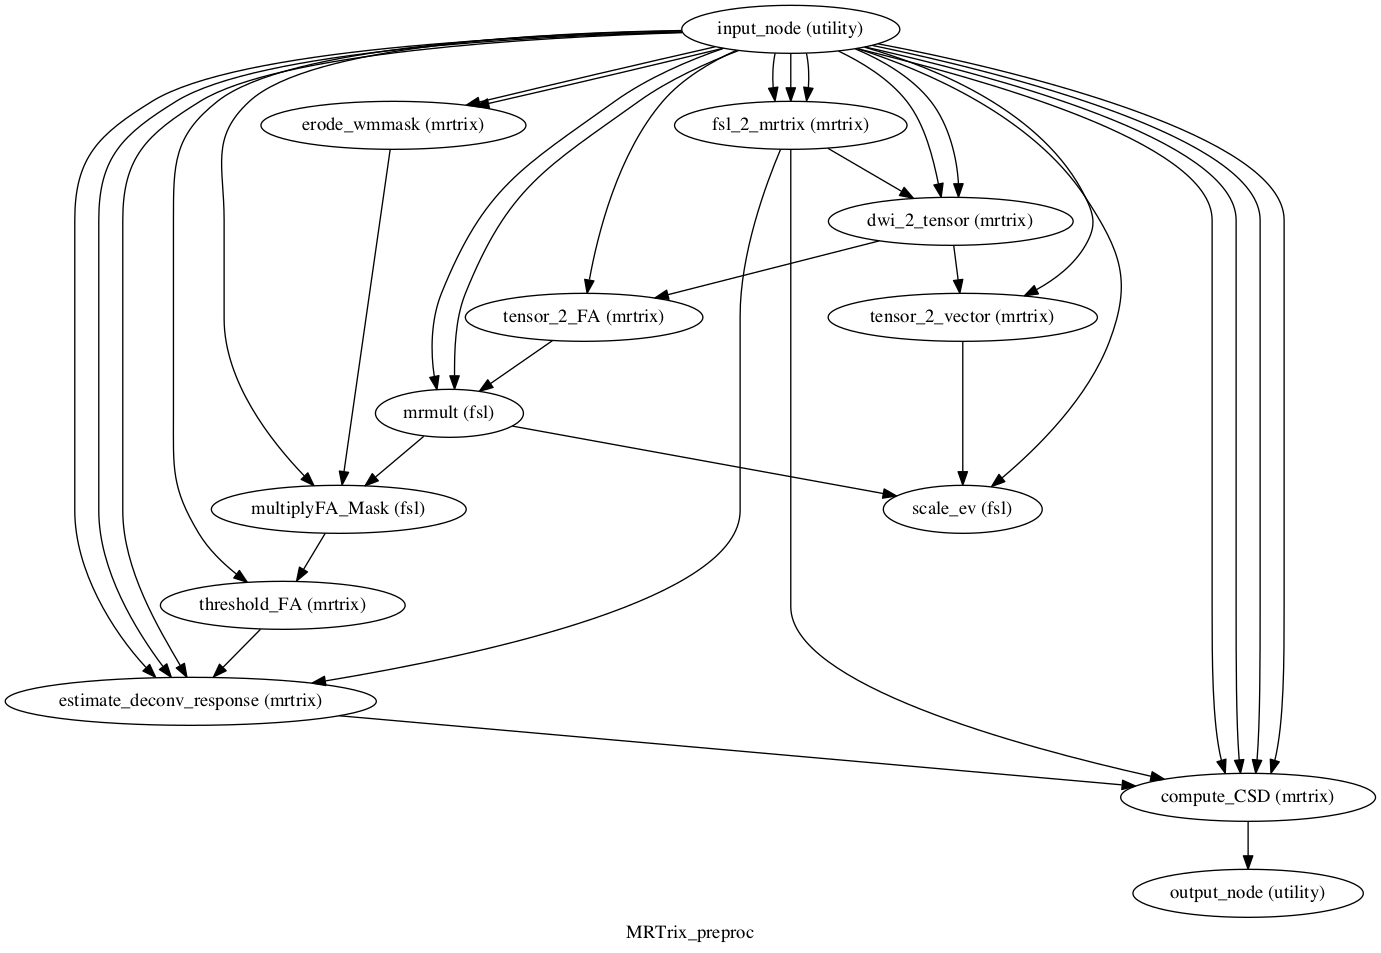

In [16]:
wf.write_graph("mrtrix_preproc_workflow_graph.dot")
from IPython.display import Image
Image(filename="mrtrix_preproc_workflow_graph.dot.png")